In [1]:
import os
import cv2
import csv
import math
import imutils
%matplotlib inline
import numpy as np
from PIL import Image
from time import sleep
from tqdm.notebook import tqdm
from scipy import ndimage as nd
from scipy.ndimage import rotate
from matplotlib import pyplot as plt
import Augmentor
import pandas as pd
from tensorflow.keras.preprocessing import image as imagePrep
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import clone_model
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

In [2]:
ReverseDownPath = r'Data\NewDataset\Reverse_Down'
ReverseUpPath = r'Data\NewDataset\Reverse_Up'
RightDownPath = r'Data\NewDataset\Right_Down'
RightUpPath = r'Data\NewDataset\Right_Up'
Labels = ['file','label']
AllPaths = [ReverseDownPath,ReverseUpPath,RightDownPath,RightUpPath]

finalRoute = r'Data\TrimmedPants'
finalCSVName = r'Data\TrimmedPants\pants_dataset.csv'
filesCSV = []

In [3]:
def checkPointCreation(checkpoint_path):
    print("saving checkpoint")
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    return cp_callback

In [4]:
def generateWeights(labels):
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(labels),y=labels)
    leng = max(labels)
    class_weight_dict = {i : class_weights[i] for i in range(leng+1)}
    print(class_weight_dict)
    return class_weight_dict

In [5]:
def generateModel(classesAmount):
    input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

    resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
    last_layer=resNet.output #We take output layers of resnet
    flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer
    
    # Add dense layer to the final output layer
    output_layer = layers.Dense(classesAmount,activation='softmax')(flatten)

    # Creating model with input and output layer
    model=models.Model(inputs=input_layer,outputs=output_layer)
    model.summary()

    for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
        layer.trainable=False
    model.summary()
    return clone_model(model)

In [6]:
def load_weights(cp_path):
    print("Getting weights")
    current_Epoch = 0
    filepath = ''
    if os.path.exists(cp_path):
        for filename in os.listdir(cp_path):
            f = os.path.join(cp_path, filename)
            # checking if it is a file
            if os.path.isfile(f):
                try:
                    lsp = filename.split('-')[1]
                    num = int(lsp.split('.')[0])
                    if(current_Epoch <= num):
                        current_Epoch = num
                        file = filename.split('.index')[0]
                        filepath = os.path.join(cp_path, file)
                        print(filepath)
                except:
                    print("not this")
        print("Starting from epoch " + str(current_Epoch))
    else:
        os.mkdir(cp_path)
    return current_Epoch, filepath

In [7]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [8]:
BATCH_SIZE = 8
EPOCHS = 20
WIDTH = 540
HEIGHT = 540
STEPS_EPOCH = 50

In [9]:
p = Augmentor.Pipeline(finalRoute)
p.resize(1, WIDTH, HEIGHT)
p.flip_left_right(0.5)
p.rotate(probability=0.3, max_left_rotation=5, max_right_rotation=5)
p.skew(0.4, 0.5)#p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.status()

Initialised with 70 image(s) found.
Output directory set to Data\TrimmedPants\output.Operations: 4
	0: Resize (probability=1 width=540 height=540 resample_filter=BICUBIC )
	1: Flip (probability=0.5 top_bottom_left_right=LEFT_RIGHT )
	2: RotateRange (probability=0.3 max_left_rotation=-5 max_right_rotation=5 )
	3: Skew (probability=0.4 skew_type=RANDOM magnitude=0.5 )
Images: 70
Classes: 4
	Class index: 0 Class label: Reverse_Down 
	Class index: 1 Class label: Reverse_Up 
	Class index: 2 Class label: Right_Down 
	Class index: 3 Class label: Right_Up 
Dimensions: 1
	Width: 255 Height: 255
Formats: 1
	 JPEG

You can remove operations using the appropriate index and the remove_operation(index) function.


In [10]:
train_set = p.keras_generator(batch_size=BATCH_SIZE)

In [11]:
csvFile = pd.read_csv(finalCSVName)
csvFile.head()
generator = imagePrep.ImageDataGenerator()
test_set = generator.flow_from_dataframe(
    dataframe=csvFile,
    x_col="file",
    y_col="label",
    target_size=(WIDTH, HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 70 validated image filenames belonging to 4 classes.


C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 2 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


In [12]:
cp_path = "checkPoints/modelTrimmed/cp-{epoch:04d}.ckpt"
cp_callback = checkPointCreation(cp_path)

saving checkpoint


In [13]:
model = generateModel(len(p.class_labels))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 546, 546, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 270, 270, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 135, 135, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 135, 135, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 135, 135, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 135, 135, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 68, 68, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 68, 68, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 68, 68, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 68, 68, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 34, 34, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 34, 34, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 34, 34, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 17, 17, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 17, 17, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 17, 17, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 17, 17, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

__________________________________________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 546, 546, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 270, 270, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

                                                                                                  
 conv2_block2_add (Add)         (None, 135, 135, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 135, 135, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 135, 135, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 68, 68, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 68, 68, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 68, 68, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 68, 68, 512)  0           ['conv3_block2_add[0][0]']       
          

                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 34, 34, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
          

 conv4_block4_2_relu (Activatio  (None, 34, 34, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 34, 34, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 34, 34, 1024  0           ['conv4_block3_out[0][0]',       
          

                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 17, 17, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 17, 17, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 17, 17, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_blo

Total params: 25,955,204
Trainable params: 2,367,492
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [14]:
currentEpoch, file = load_weights("checkPoints/modelTrimmed")
if(currentEpoch != 0):
    model.load_weights(file)

Getting weights


In [15]:
model.fit(train_set,steps_per_epoch=STEPS_EPOCH,epochs=EPOCHS,initial_epoch = currentEpoch,verbose=True, callbacks=[cp_callback])

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 1.8137 - accuracy: 0.4175
Epoch 1: saving model to checkPoints/modelTrimmed\cp-0001.ckpt
50/50 [==============================] - 20s 274ms/step - loss: 1.8137 - accuracy: 0.4175
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.7614 - accuracy: 0.7175
Epoch 2: saving model to checkPoints/modelTrimmed\cp-0002.ckpt
50/50 [==============================] - 14s 279ms/step - loss: 0.7614 - accuracy: 0.7175
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.5493 - accuracy: 0.7825
Epoch 3: saving model to checkPoints/modelTrimmed\cp-0003.ckpt
50/50 [==============================] - 14s 275ms/step - loss: 0.5493 - accuracy: 0.7825
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.4567 - accuracy: 0.8375
Epoch 4: saving model to checkPoints/modelTrimmed\cp-0004.ckpt
50/50 [==============================] - 14s 281ms/step - loss: 0.4567 - accuracy: 0.8375
Epoch 5/20
5

In [16]:
if(currentEpoch < EPOCHS):
    model.save('saved_model/trimmed')

INFO:tensorflow:Assets written to: saved_model/trimmed\assets


In [17]:
model = models.load_model('saved_model/trimmed')

In [18]:
predictions = model.predict(test_set)
rounded_predictions = np.argmax(predictions, axis=-1)
model.evaluate(test_set)

70/70 [==============================] - 4s 42ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

Confusion matrix, without normalization
[[8 4 4 1]
 [6 4 4 4]
 [3 4 2 7]
 [0 6 6 7]]


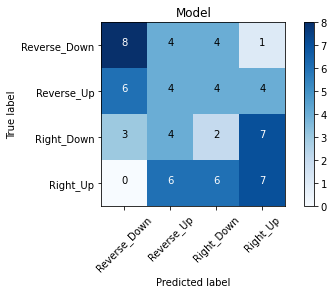

In [19]:
cm = confusion_matrix(y_true=test_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=test_set.class_indices, title='Model')